In [1]:
import numpy as np
import matplotlib.pyplot as pl
import json
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.abspath(os.path.join('../src/'))

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from labelsUtils import Label, LabelCategory, categories_from_label_set
from regionUtils import vietnam_labels_coordinates
from rasterUtils import make_dataset_from_raster_files
from bandUtils import Band
from visualizationUtils import plot_confusion_matrix
from lossesUtils import weighted_categorical_crossentropy, categorical_focal_loss
from convNetUtils import (
    cross_validation,
    evaluate_multi_output_model,
    compute_class_weights,
    images_from_dataset,
    labels_from_dataset,
    train_model,
    AUGMENTATIONS,
    ImageMultiOutputSequence,
)

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [30]:
EPOCHS = 500
DATA_ROOT_PATH = '../data/'
MODEL_ROOT_PATH = '../models/' 
LABELS_COORDINATES = vietnam_labels_coordinates()

In [3]:
# Only labels that contains georeferenced points.
labels = [
    Label.COFFEE,
    Label.NATIVEVEGE,
    Label.RUBBER,
    Label.SEASONAL,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    # Label.CASSAVA, # /!\ only 4 images
    Label.TEA,
    Label.RICE,
    Label.INTERCROP,
    Label.DECIDUOUS_FOREST,
    Label.STICK_PEPPER,
    Label.PINE_TREES,
]

In [4]:
NB_PIXEL_AROUND=4

In [5]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2018_january_to_april/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2018)

In [6]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2019_january_to_april/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [7]:
labels_names = [label.name for label in labels]
nb_labels = len(labels_names)

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [8]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(LabelCategory)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(LabelCategory)), 
]

In [9]:
labels_train_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_train),
    y=labels_train
)

categories_train_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(categories_train),
    y=categories_train
)

In [10]:
# images have all the same shapes, take the shape of the first image
image_width = 9
image_height = 9
image_depth = len(bands)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(1./2**16)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D()(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

## Categorical cross entropy

In [11]:
model_name = "january_to_april_2018_multi_output"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': weighted_categorical_crossentropy(labels_train_weights),
    'category': weighted_categorical_crossentropy(categories_train_weights)
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(MODEL_ROOT_PATH + model_name + '.hdf5')

Epoch 1/500
432/432 [==============================] - 2s 3ms/step - loss: 3.7427 - label_loss: 2.4032 - category_loss: 1.3394 - label_accuracy: 0.1703 - category_accuracy: 0.3594
Epoch 2/500
432/432 [==============================] - 1s 3ms/step - loss: 3.1702 - label_loss: 2.0802 - category_loss: 1.0899 - label_accuracy: 0.2599 - category_accuracy: 0.4471
Epoch 3/500
432/432 [==============================] - 1s 3ms/step - loss: 2.9234 - label_loss: 1.9339 - category_loss: 0.9895 - label_accuracy: 0.2872 - category_accuracy: 0.5090
Epoch 4/500
432/432 [==============================] - 1s 3ms/step - loss: 2.7363 - label_loss: 1.8229 - category_loss: 0.9134 - label_accuracy: 0.3044 - category_accuracy: 0.5575
Epoch 5/500
432/432 [==============================] - 1s 3ms/step - loss: 2.6815 - label_loss: 1.7883 - category_loss: 0.8932 - label_accuracy: 0.3237 - category_accuracy: 0.5748
Epoch 6/500
432/432 [==============================] - 1s 3ms/step - loss: 2.4624 - label_loss: 1.65

432/432 [==============================] - 2s 4ms/step - loss: 1.3433 - label_loss: 0.9624 - category_loss: 0.3809 - label_accuracy: 0.5232 - category_accuracy: 0.7767
Epoch 92/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2261 - label_loss: 0.8891 - category_loss: 0.3369 - label_accuracy: 0.5470 - category_accuracy: 0.7827
Epoch 93/500
432/432 [==============================] - 2s 5ms/step - loss: 1.3909 - label_loss: 0.9695 - category_loss: 0.4214 - label_accuracy: 0.5493 - category_accuracy: 0.7754
Epoch 94/500
432/432 [==============================] - 2s 4ms/step - loss: 1.3004 - label_loss: 0.9368 - category_loss: 0.3636 - label_accuracy: 0.5513 - category_accuracy: 0.7936
Epoch 95/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1878 - label_loss: 0.8437 - category_loss: 0.3441 - label_accuracy: 0.5624 - category_accuracy: 0.7958
Epoch 96/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1142 - label_loss: 0.8031 - ca

432/432 [==============================] - 2s 5ms/step - loss: 1.6363 - label_loss: 1.2261 - category_loss: 0.4102 - label_accuracy: 0.5196 - category_accuracy: 0.7707
Epoch 182/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2299 - label_loss: 0.8831 - category_loss: 0.3468 - label_accuracy: 0.5597 - category_accuracy: 0.7938
Epoch 183/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1552 - label_loss: 0.8363 - category_loss: 0.3189 - label_accuracy: 0.5866 - category_accuracy: 0.8103
Epoch 184/500
432/432 [==============================] - 2s 5ms/step - loss: 1.3333 - label_loss: 0.9215 - category_loss: 0.4118 - label_accuracy: 0.5522 - category_accuracy: 0.8079
Epoch 185/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2878 - label_loss: 0.9280 - category_loss: 0.3598 - label_accuracy: 0.5338 - category_accuracy: 0.7858
Epoch 186/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5112 - label_loss: 1.0537

432/432 [==============================] - 2s 5ms/step - loss: 1.1482 - label_loss: 0.8395 - category_loss: 0.3088 - label_accuracy: 0.5888 - category_accuracy: 0.8074
Epoch 272/500
432/432 [==============================] - 2s 5ms/step - loss: 1.0464 - label_loss: 0.7544 - category_loss: 0.2920 - label_accuracy: 0.5879 - category_accuracy: 0.8184
Epoch 273/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1626 - label_loss: 0.8383 - category_loss: 0.3243 - label_accuracy: 0.5743 - category_accuracy: 0.8142
Epoch 274/500
432/432 [==============================] - 2s 5ms/step - loss: 1.3038 - label_loss: 0.8917 - category_loss: 0.4120 - label_accuracy: 0.5819 - category_accuracy: 0.8047
Epoch 275/500
432/432 [==============================] - 2s 5ms/step - loss: 1.0713 - label_loss: 0.7598 - category_loss: 0.3115 - label_accuracy: 0.5907 - category_accuracy: 0.8152
Epoch 276/500
432/432 [==============================] - 2s 5ms/step - loss: 1.4919 - label_loss: 1.0610

432/432 [==============================] - 2s 5ms/step - loss: 1.8095 - label_loss: 1.1724 - category_loss: 0.6371 - label_accuracy: 0.5087 - category_accuracy: 0.7517
Epoch 362/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5428 - label_loss: 1.1001 - category_loss: 0.4427 - label_accuracy: 0.5266 - category_accuracy: 0.7745
Epoch 363/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5222 - label_loss: 1.0802 - category_loss: 0.4421 - label_accuracy: 0.5158 - category_accuracy: 0.7665
Epoch 364/500
432/432 [==============================] - 2s 5ms/step - loss: 1.8840 - label_loss: 1.3469 - category_loss: 0.5371 - label_accuracy: 0.4940 - category_accuracy: 0.7499
Epoch 365/500
432/432 [==============================] - 2s 5ms/step - loss: 1.7076 - label_loss: 1.2829 - category_loss: 0.4247 - label_accuracy: 0.5357 - category_accuracy: 0.7698
Epoch 366/500
432/432 [==============================] - 2s 5ms/step - loss: 1.7681 - label_loss: 1.2627

432/432 [==============================] - 2s 5ms/step - loss: 1.2105 - label_loss: 0.9040 - category_loss: 0.3064 - label_accuracy: 0.5999 - category_accuracy: 0.8145
Epoch 452/500
432/432 [==============================] - 2s 5ms/step - loss: 1.4673 - label_loss: 1.0809 - category_loss: 0.3864 - label_accuracy: 0.5589 - category_accuracy: 0.8033
Epoch 453/500
432/432 [==============================] - 2s 5ms/step - loss: 1.2972 - label_loss: 0.9863 - category_loss: 0.3109 - label_accuracy: 0.5772 - category_accuracy: 0.8100
Epoch 454/500
432/432 [==============================] - 2s 5ms/step - loss: 1.1400 - label_loss: 0.8324 - category_loss: 0.3076 - label_accuracy: 0.5892 - category_accuracy: 0.8201
Epoch 455/500
432/432 [==============================] - 2s 5ms/step - loss: 1.5430 - label_loss: 1.1413 - category_loss: 0.4017 - label_accuracy: 0.5489 - category_accuracy: 0.7965
Epoch 456/500
432/432 [==============================] - 2s 5ms/step - loss: 1.8771 - label_loss: 1.4038

In [13]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [14]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  1.799280047416687
accuracy:  1.3452645540237427


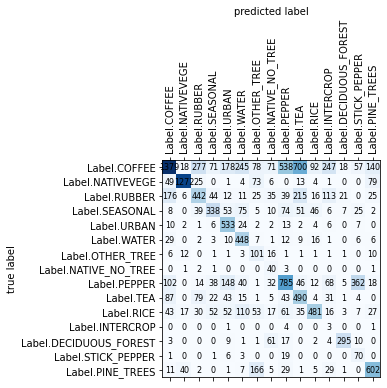

In [15]:
plot_confusion_matrix(conf_matrices[0], labels)

In [16]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.72426471 0.92982456 0.48411829 0.58578856 0.50858779 0.45436105
 0.19688109 0.13289037 0.47924298 0.31349968 0.70424597 0.00570342
 0.83806818 0.12773723 0.66081229]
Mean precision:  0.4764017450381963

Recalls:  [0.33560477 0.83300589 0.37457627 0.45737483 0.87091503 0.81454545
 0.6516129  0.83333333 0.46977858 0.59393939 0.47908367 0.33333333
 0.73200993 0.7        0.66963293]
Mean recall:  0.6099164206063695

F-Score:  [0.45867288 0.87875648 0.42236025 0.51367781 0.64216867 0.58333333
 0.30239521 0.22922636 0.47446358 0.41038526 0.57024303 0.01121495
 0.78145695 0.21604938 0.66519337]
Mean f-score:  0.4773065019551172


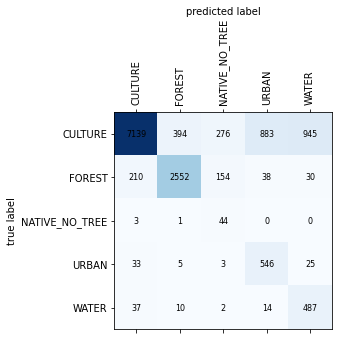

In [17]:
plot_confusion_matrix(conf_matrices[1], [label.name for label in LabelCategory])

In [18]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.96187012 0.86158001 0.09185804 0.36866982 0.32750504]
Mean precision:  0.5222966056714663

Recalls:  [0.7407907  0.85522788 0.91666667 0.89215686 0.88545455]
Mean recall:  0.8580593318809244

F-Score:  [0.83697755 0.8583922  0.16698292 0.52173913 0.47815415]
Mean f-score:  0.5724491891671718


## Categorical focal loss

In [19]:
model_name = "january_to_april_2018_multi_output_focal_loss"

# Specify optimizer and loss function
model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels_names)]),
    'category': categorical_focal_loss([[.25] * len(LabelCategory)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [20]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(MODEL_ROOT_PATH + model_name + '.hdf5')

Epoch 1/500
432/432 [==============================] - 3s 5ms/step - loss: 0.1892 - label_loss: 0.1586 - category_loss: 0.0306 - label_accuracy: 0.6610 - category_accuracy: 0.8928
Epoch 2/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1668 - label_loss: 0.1418 - category_loss: 0.0250 - label_accuracy: 0.6772 - category_accuracy: 0.9059
Epoch 3/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1583 - label_loss: 0.1355 - category_loss: 0.0229 - label_accuracy: 0.6935 - category_accuracy: 0.9067
Epoch 4/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1515 - label_loss: 0.1298 - category_loss: 0.0217 - label_accuracy: 0.6961 - category_accuracy: 0.9097
Epoch 5/500
432/432 [==============================] - 2s 5ms/step - loss: 0.1468 - label_loss: 0.1257 - category_loss: 0.0210 - label_accuracy: 0.7037 - category_accuracy: 0.9138
Epoch 6/500
432/432 [==============================] - 2s 6ms/step - loss: 0.1461 - label_loss: 0.12

432/432 [==============================] - 3s 6ms/step - loss: 0.1018 - label_loss: 0.0866 - category_loss: 0.0152 - label_accuracy: 0.7660 - category_accuracy: 0.9306
Epoch 92/500
432/432 [==============================] - 3s 6ms/step - loss: 0.0969 - label_loss: 0.0825 - category_loss: 0.0144 - label_accuracy: 0.7734 - category_accuracy: 0.9339
Epoch 93/500
432/432 [==============================] - 3s 6ms/step - loss: 0.1006 - label_loss: 0.0855 - category_loss: 0.0150 - label_accuracy: 0.7701 - category_accuracy: 0.9318
Epoch 94/500
432/432 [==============================] - 3s 7ms/step - loss: 0.0983 - label_loss: 0.0836 - category_loss: 0.0148 - label_accuracy: 0.7688 - category_accuracy: 0.9336
Epoch 95/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0993 - label_loss: 0.0845 - category_loss: 0.0149 - label_accuracy: 0.7715 - category_accuracy: 0.9351
Epoch 96/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0951 - label_loss: 0.0809 - ca

432/432 [==============================] - 2s 5ms/step - loss: 0.0851 - label_loss: 0.0720 - category_loss: 0.0130 - label_accuracy: 0.7928 - category_accuracy: 0.9433
Epoch 182/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0884 - label_loss: 0.0745 - category_loss: 0.0140 - label_accuracy: 0.7931 - category_accuracy: 0.9397
Epoch 183/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0888 - label_loss: 0.0749 - category_loss: 0.0139 - label_accuracy: 0.7941 - category_accuracy: 0.9401
Epoch 184/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0888 - label_loss: 0.0748 - category_loss: 0.0140 - label_accuracy: 0.7920 - category_accuracy: 0.9408
Epoch 185/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0855 - label_loss: 0.0723 - category_loss: 0.0132 - label_accuracy: 0.7921 - category_accuracy: 0.9383
Epoch 186/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0854 - label_loss: 0.0719

432/432 [==============================] - 2s 5ms/step - loss: 0.0807 - label_loss: 0.0681 - category_loss: 0.0126 - label_accuracy: 0.8042 - category_accuracy: 0.9437
Epoch 272/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0774 - label_loss: 0.0651 - category_loss: 0.0123 - label_accuracy: 0.8095 - category_accuracy: 0.9426
Epoch 273/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0816 - label_loss: 0.0687 - category_loss: 0.0129 - label_accuracy: 0.8001 - category_accuracy: 0.9426
Epoch 274/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0838 - label_loss: 0.0703 - category_loss: 0.0135 - label_accuracy: 0.7965 - category_accuracy: 0.9396
Epoch 275/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0803 - label_loss: 0.0674 - category_loss: 0.0129 - label_accuracy: 0.8023 - category_accuracy: 0.9442
Epoch 276/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0809 - label_loss: 0.0681

432/432 [==============================] - 2s 5ms/step - loss: 0.0771 - label_loss: 0.0644 - category_loss: 0.0126 - label_accuracy: 0.8095 - category_accuracy: 0.9457
Epoch 362/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0775 - label_loss: 0.0645 - category_loss: 0.0130 - label_accuracy: 0.8091 - category_accuracy: 0.9451
Epoch 363/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0796 - label_loss: 0.0667 - category_loss: 0.0129 - label_accuracy: 0.8086 - category_accuracy: 0.9455
Epoch 364/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0752 - label_loss: 0.0627 - category_loss: 0.0126 - label_accuracy: 0.8137 - category_accuracy: 0.9435
Epoch 365/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0759 - label_loss: 0.0633 - category_loss: 0.0126 - label_accuracy: 0.8138 - category_accuracy: 0.9436
Epoch 366/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0753 - label_loss: 0.0633

432/432 [==============================] - 2s 5ms/step - loss: 0.0750 - label_loss: 0.0627 - category_loss: 0.0123 - label_accuracy: 0.8119 - category_accuracy: 0.9449
Epoch 452/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0701 - label_loss: 0.0589 - category_loss: 0.0112 - label_accuracy: 0.8240 - category_accuracy: 0.9489
Epoch 453/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0750 - label_loss: 0.0630 - category_loss: 0.0120 - label_accuracy: 0.8143 - category_accuracy: 0.9467
Epoch 454/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0727 - label_loss: 0.0607 - category_loss: 0.0120 - label_accuracy: 0.8186 - category_accuracy: 0.9463
Epoch 455/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0701 - label_loss: 0.0587 - category_loss: 0.0114 - label_accuracy: 0.8185 - category_accuracy: 0.9488
Epoch 456/500
432/432 [==============================] - 2s 5ms/step - loss: 0.0746 - label_loss: 0.0620

In [21]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [22]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.16796304285526276
accuracy:  0.1413089632987976


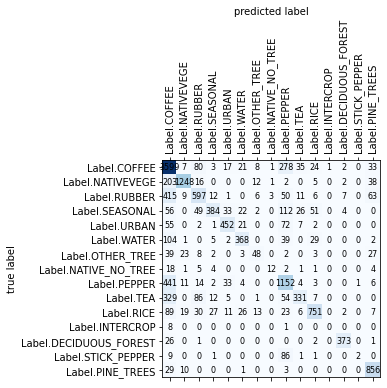

In [23]:
plot_confusion_matrix(conf_matrices[0], labels)

In [24]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.66402214 0.93905192 0.6722973  0.84768212 0.81588448 0.78969957
 0.53333333 0.70588235 0.61407249 0.78436019 0.84858757 0.
 0.95641026 0.66666667 0.82545805]
Mean precision:  0.7108938959399197

Recalls:  [0.87588221 0.8172888  0.5059322  0.51962111 0.73856209 0.66909091
 0.30967742 0.25       0.68940754 0.40121212 0.74800797 0.
 0.92555831 0.02       0.95216908]
Mean recall:  0.5614939842295434

F-Score:  [0.75537832 0.87394958 0.57736944 0.6442953  0.77530017 0.72440945
 0.39183673 0.36923077 0.64956301 0.5308741  0.7951297         nan
 0.9407314  0.03883495 0.88429752]
Mean f-score:  nan


/home/simon/Documents/HEIG/TB/scripts/src/statisticsUtils.py:106: RuntimeWarning: invalid value encountered in true_divide
  fscore = 2 * recall * precision / (recall + precision)


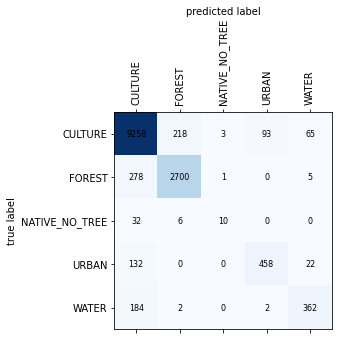

In [25]:
plot_confusion_matrix(conf_matrices[1], [label.name for label in LabelCategory])

In [26]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.93666532 0.92276145 0.71428571 0.82820976 0.79735683]
Mean precision:  0.8398558148321117

Recalls:  [0.96067241 0.90482574 0.20833333 0.74836601 0.65818182]
Mean recall:  0.6960758620556643

F-Score:  [0.94851698 0.91370558 0.32258065 0.78626609 0.72111554]
Mean f-score:  0.7384369685797689
